In [1]:
!pip install netgraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from netgraph import Graph

class StateDiagram:
    def __init__(self, nodes, edges, edges_labels):
        self.nodes          = nodes
        self.edges          = edges
        self.nodes_shape    = 'o'
        self.edges_labels   = edges_labels
        self.shift  = {
            'u': [0, 0.1],
            'd': [0, -0.1],
            'r': [0.15, 0],
            'l': [-0.15, 0],
        }

    def set_shape(self, terminal=''):
        self.nodes_shape = {node: 'o' if node != terminal else 's' for node in self.nodes}

    def plot(self, figsize=(15, 15), rad=0.15, node_color='yellow', sub_label=None):
        import sys
        import matplotlib.pyplot as plt
        from netgraph import Graph
        plt.figure(figsize=figsize)

        G = nx.DiGraph(directed=True)
        G.add_nodes_from(self.nodes)
        G.add_edges_from(self.edges)

        pos = nx.shell_layout(G)

        if sub_label:
            dir = sub_label['dir']

            shifted_pos = {}
            for node in self.nodes:
                shifted_pos[node] = pos[node] + self.shift[dir[node]]
            
            s_label = sub_label['label']

            nx.draw_networkx_labels(G, shifted_pos, labels=s_label, horizontalalignment="center", font_color='r', font_size=12)

        Graph(G, node_layout=pos, edge_layout='arc', origin=(0, 0), scale=(1, 1),
            node_size=8., node_color=node_color,
            node_labels=True, node_label_fontdict=dict(size=10), arrows=True, 
            edge_labels=self.edges_labels, edge_label_fontdict=dict(size=15),
            edge_layout_kwargs={'rad':rad},
            node_shape=self.nodes_shape
        )

        plt.show()

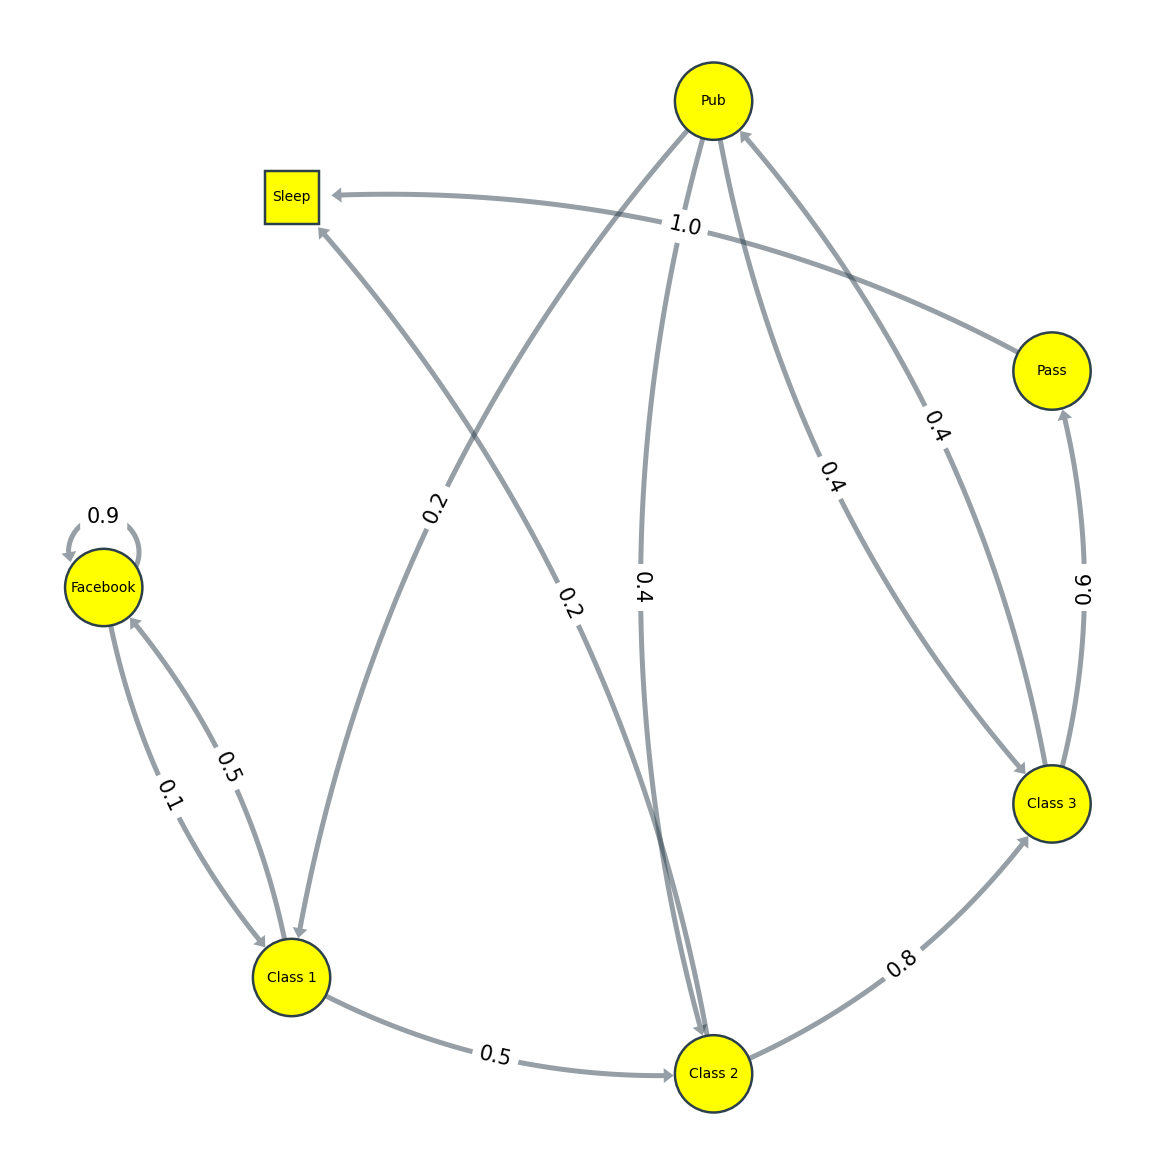

In [3]:
nodes = ["Facebook", "Class 1", "Class 2", "Class 3", "Pass", "Pub", "Sleep"]

edges_transition = {
    ("Facebook", "Facebook") : 0.9,
    ("Facebook", "Class 1") : 0.1,
    ("Class 1", "Class 2") : 0.5,
    ("Class 1", "Facebook") : 0.5,
    ("Class 2", "Class 3") : 0.8,
    ("Class 2", "Sleep") : 0.2,
    ("Class 3", "Pass") : 0.6,
    ("Class 3", "Pub") : 0.4,
    ("Pub", "Class 1") : 0.2,
    ("Pub", "Class 2") : 0.4,
    ("Pub", "Class 3") : 0.4,
    ("Pass", "Sleep") : 1.0
    }

edges = list(edges_transition.keys())

state = StateDiagram(nodes, edges, edges_transition)
state.set_shape(terminal = 'Sleep')

state.plot()

<Figure size 1500x1500 with 0 Axes>

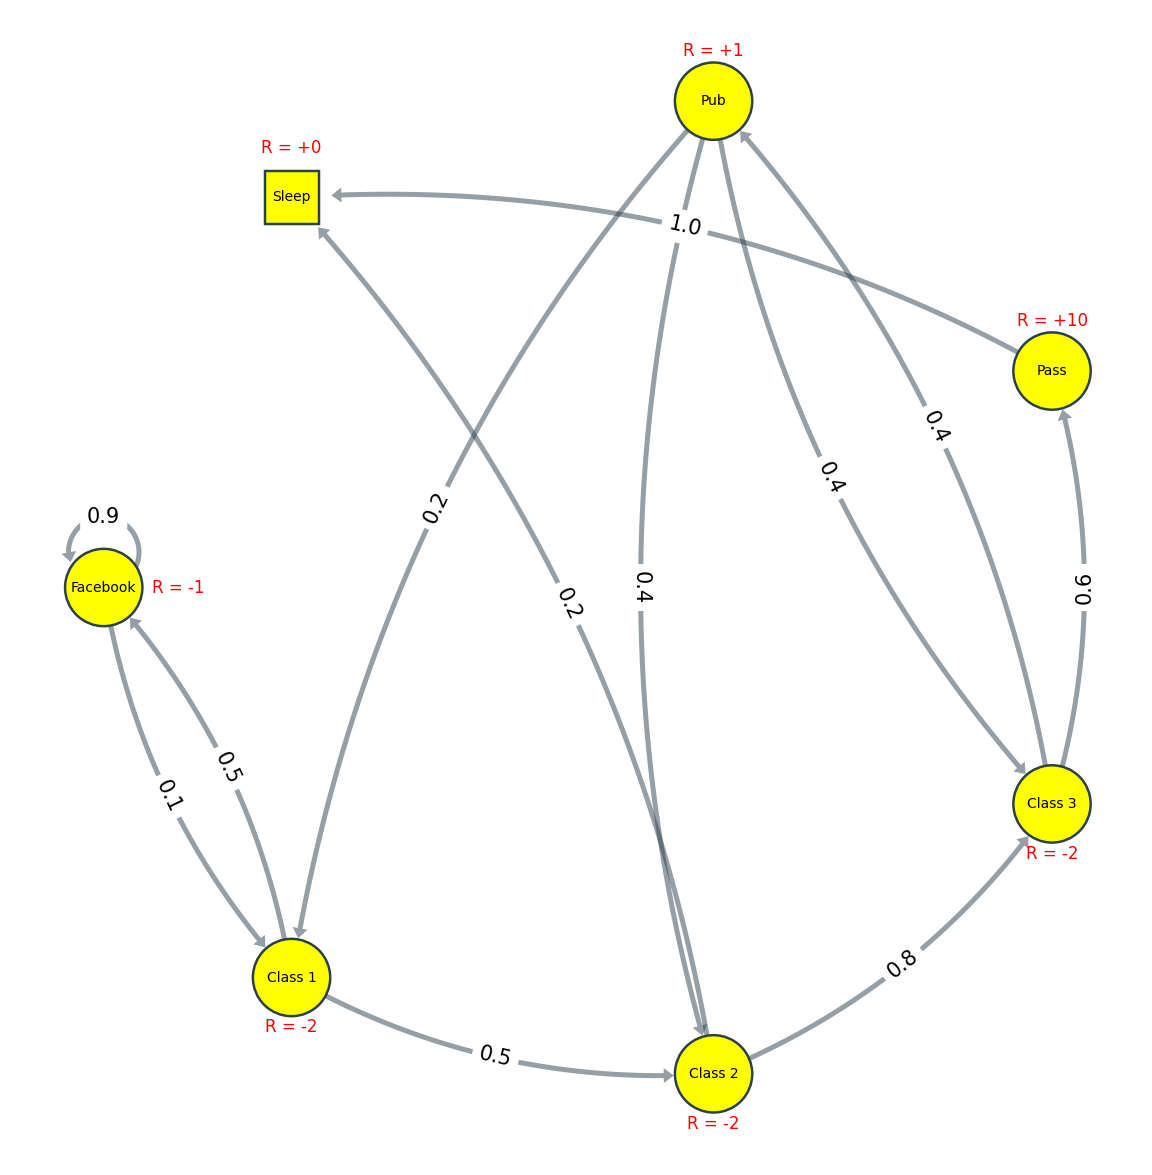

In [4]:
import numpy as np

class MRPState(StateDiagram):
    def __init__(self, nodes, edges, transition, rewards, dir):
        super().__init__(nodes, edges, transition)
        self.rewards = rewards
        self.nodes_rewards = {nodes[i]: f'R = {rewards[i]:+}' for i in range(len(nodes))}
        self.sub_label = {
            'dir' : dir,
            'label' : self.nodes_rewards
        }

    def plot(self, mapping=None):
        plt.figure(figsize=(15, 15))

        if mapping:
            self._map_result(mapping)

        super().plot(sub_label=self.sub_label)

    def _map_result(self, mapping):
        self.nodes = [mapping[node] for node in self.nodes]
        self.nodes_rewards = {mapping[node]: reward for node, reward in self.nodes_rewards.items()}
        self.nodes_shape = {mapping[node]: shape for node, shape in self.nodes_shape.items()}
        self.edges_labels = {(mapping[node_f], mapping[node_t]): prob for (node_f, node_t), prob in self.edges_labels.items()}
        self.sub_label = {
            'dir' : {mapping[node]: direction for node, direction in self.sub_label['dir'].items()},
            'label' : self.nodes_rewards
        }

        self.edges = [(mapping[node_f], mapping[node_t]) for (node_f, node_t) in self.edges]
    
    def _unmap_result(self):
        
        self.nodes = [node.split("\n")[0] for node in self.nodes]
        self.nodes_rewards = {node.split("\n")[0]: reward for node, reward in self.nodes_rewards.items()}
        self.nodes_shape = {node.split("\n")[0]: shape for node, shape in self.nodes_shape.items()}
        self.edges_labels = {(node_f.split("\n")[0], node_t.split("\n")[0]): prob for (node_f, node_t), prob in self.edges_labels.items()}
        self.sub_label = {
            'dir' : {node.split("\n")[0]: direction for node, direction in self.sub_label['dir'].items()},
            'label' : self.nodes_rewards
        }

        self.edges = [(node_f.split("\n")[0], node_t.split("\n")[0]) for (node_f, node_t) in self.edges]

    def _bellman(self, R:np.matrix, P:np.matrix, gamma=0, epoch=1000, epsilon=1e-8):
        def diff(A:np.matrix, B:np.matrix):
            if A.shape != B.shape:
                raise Exception(f"Shape of two matrices are different : {A.shape} != {B.shape}")
            else:
                return np.concatenate(np.power(A - B, 2)).sum()

        V = np.ones(R.shape)

        for i in range(epoch):
            _ = R + gamma * P * V
            if diff(_, V) < epsilon:
                break # convergence
            V = _
        return V

    def _nodes_transition_to_matrix(self, nodes:list, edges_transition:dict):
        length = len(nodes)
        shape = (length, length)
        P = np.zeros(shape)
        for i, node_from in enumerate(nodes):
            for j, node_to in enumerate(nodes):
                edge = (node_from, node_to)
                if edge in edges_transition.keys():
                    P[i][j] = edges_transition[edge]
        return np.asmatrix(P)

    def converge(self, gamma):
        P = self._nodes_transition_to_matrix(self.nodes, self.edges_labels)

        R = np.asmatrix(self.rewards).T

        V = self._bellman(R, P, gamma=gamma)

        mapping =  {node: f'{node}\n{value.item():+.1f}' for value, node in zip(V, self.nodes)}

        self.plot(mapping)

        self._unmap_result()
    
    def print(self):
        print(self.nodes)
        print(self.edges)
        print(self.edges_labels)
        print(self.rewards)
        print(self.nodes_rewards)
        print(self.sub_label)

nodes = ["Facebook", "Class 1", "Class 2", "Class 3", "Pass", "Pub", "Sleep"]

rewards = [-1, -2, -2, -2, 10, 1, 0]

edges_transition = {
    ("Facebook", "Facebook") : 0.9,
    ("Facebook", "Class 1") : 0.1,
    ("Class 1", "Class 2") : 0.5,
    ("Class 1", "Facebook") : 0.5,
    ("Class 2", "Class 3") : 0.8,
    ("Class 2", "Sleep") : 0.2,
    ("Class 3", "Pass") : 0.6,
    ("Class 3", "Pub") : 0.4,
    ("Pub", "Class 1") : 0.2,
    ("Pub", "Class 2") : 0.4,
    ("Pub", "Class 3") : 0.4,
    ("Pass", "Sleep") : 1.0
    }

edges = list(edges_transition.keys())

dir = {
        "Facebook"  : 'r',
        "Class 1"   : 'd',
        "Class 2"   : 'd',
        "Class 3"   : 'd',
        "Pass"      : 'u',
        "Pub"       : 'u',
        "Sleep"     : 'u'
    }

state = MRPState(nodes, edges, edges_transition, rewards, dir)
state.set_shape(terminal='Sleep')

state.plot()

<Figure size 1500x1500 with 0 Axes>

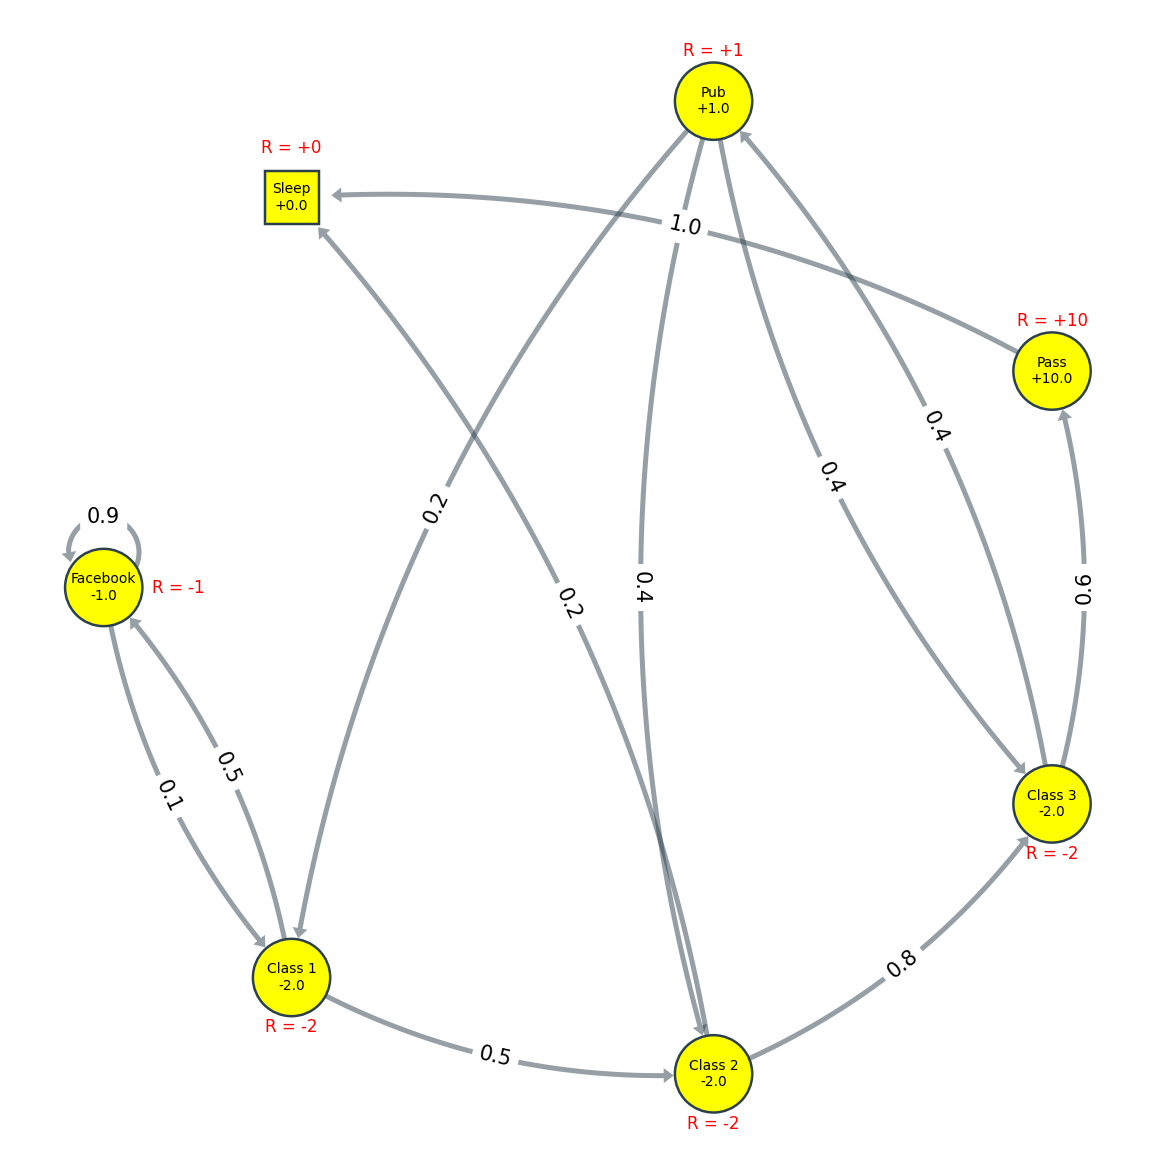

<Figure size 1500x1500 with 0 Axes>

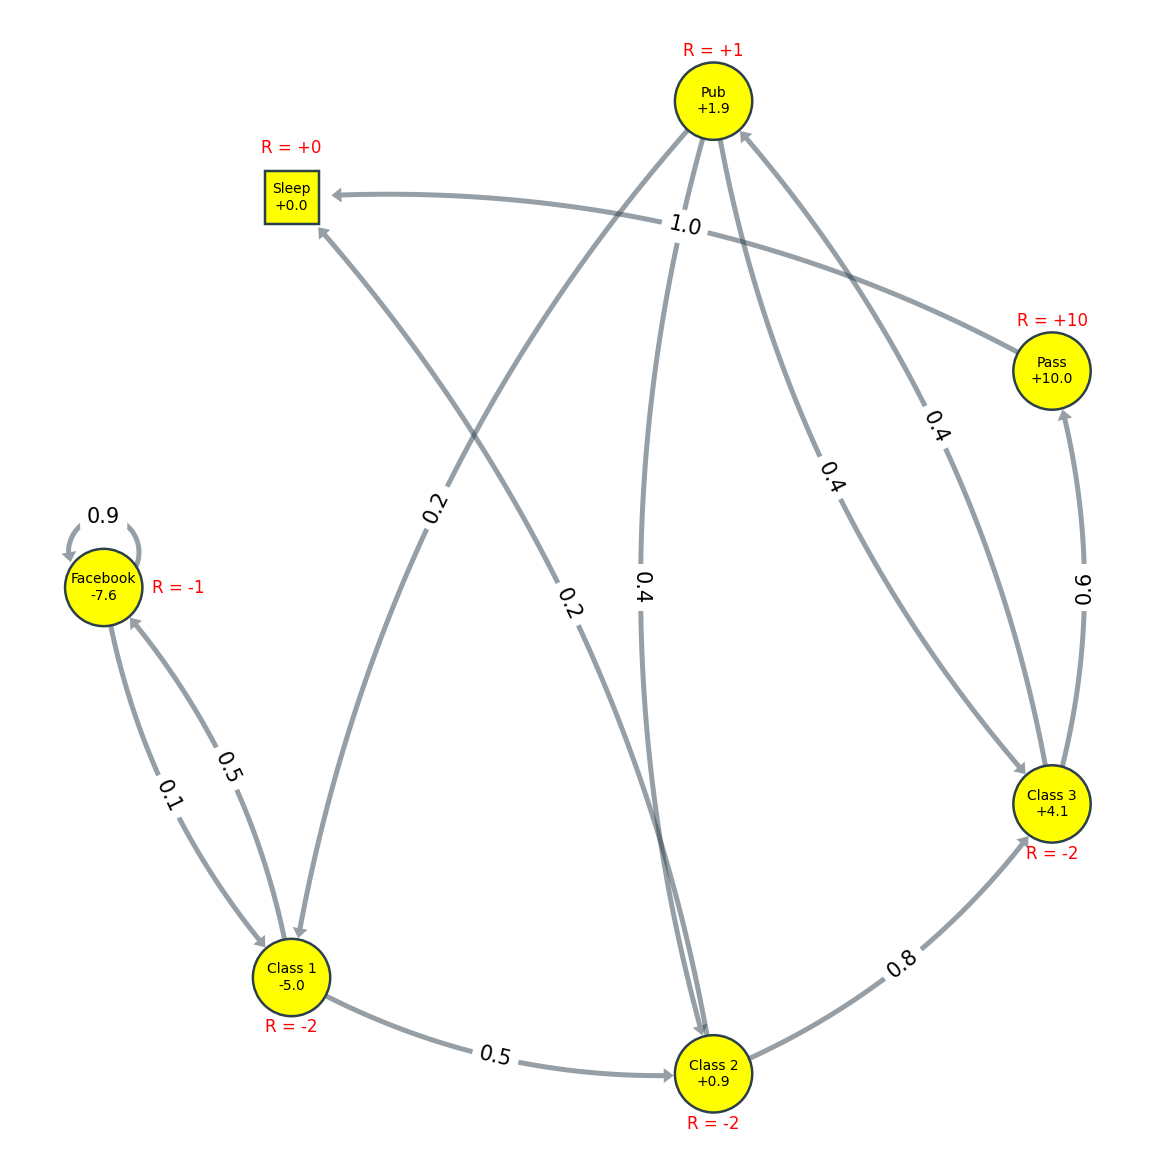

<Figure size 1500x1500 with 0 Axes>

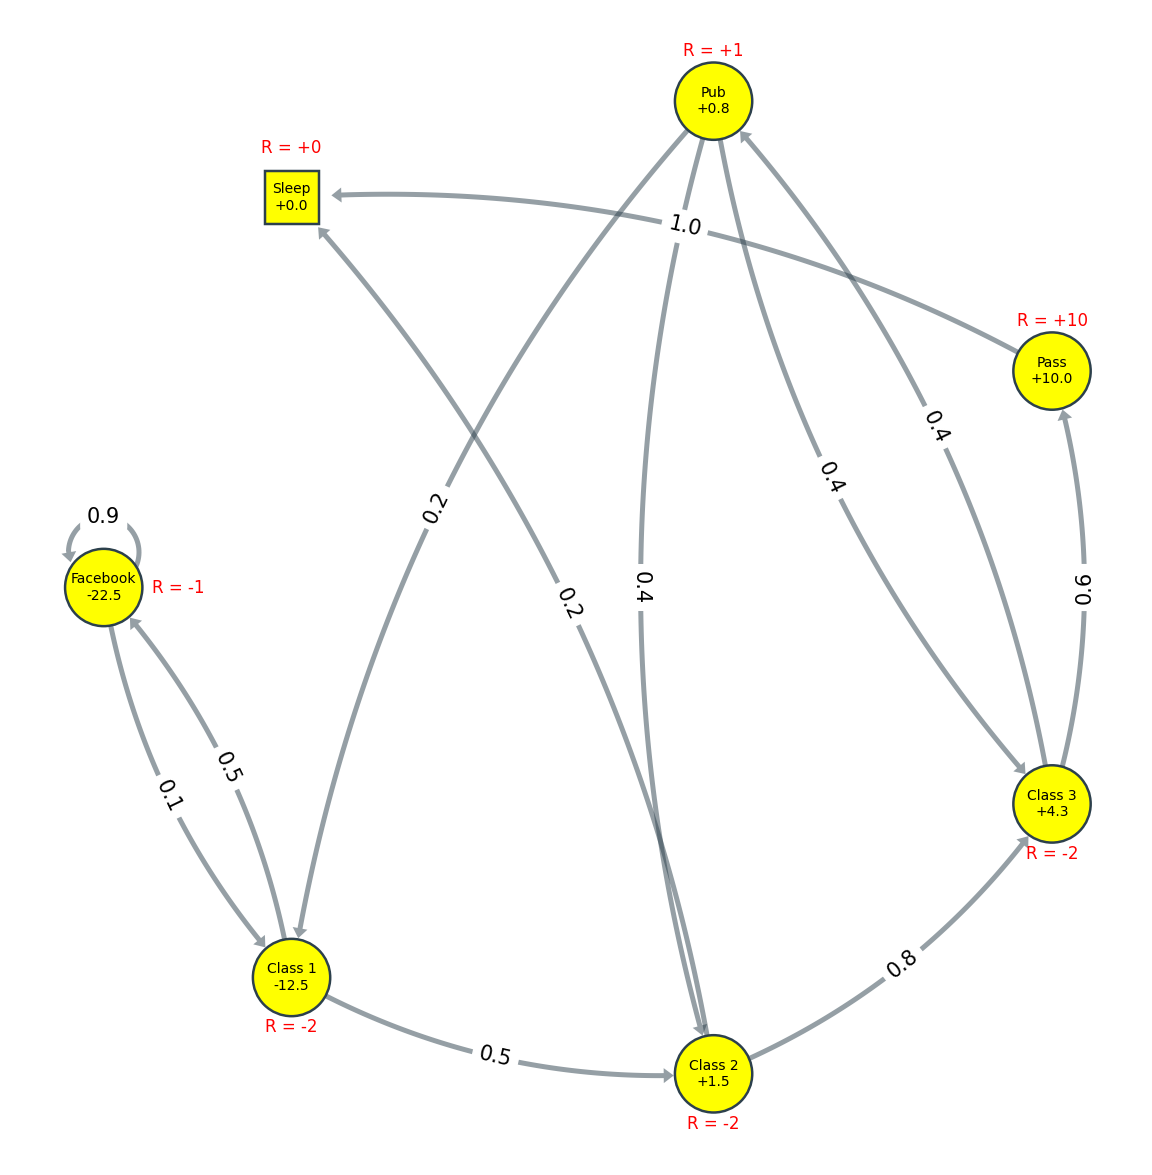

In [5]:
for gamma in [0, 0.9, 1]:
    state.converge(gamma)

In [6]:
# plt.figure(figsize=(15, 15))

# G = nx.DiGraph(directed=True)

# G.add_nodes_from(nodes)

# G.add_edges_from(list(edges_transition.keys()))

# pos = nx.shell_layout(G)

# shift = [0, -0.12]
# shifted_pos = {node: node_pos + shift for node, node_pos in pos.items()}
# shifted_pos["Facebook"] = shifted_pos["Facebook"] - [0, -0.12] + [0.15, 0.0]
# shifted_pos["Pass"]     = shifted_pos["Pass"] - [0, -0.12] - [0, -0.1]
# shifted_pos["Pub"]      = shifted_pos["Pub"] - [0, -0.12] - [0, -0.1]
# shifted_pos["Sleep"]    = shifted_pos["Sleep"] - [0, -0.12] - [0, -0.1]

# nx.draw_networkx_labels(G, shifted_pos, labels=nodes_rewards, horizontalalignment="center", font_color='r', font_size=12)

# Graph(G, node_layout=pos, edge_layout='arc', origin=(0, 0), scale=(1, 1),
#     node_size=8., node_color='yellow',
#     node_labels=True, node_label_fontdict=dict(size=10), arrows=True, 
#     edge_labels=edges_transition, edge_label_fontdict=dict(size=15), #edge_label_position = 0.5,
#     edge_layout_kwargs={'rad':0.15},
#     node_shape=nodes_shape
# )


# plt.show()

In [7]:
'''
P = nodes_transition_to_matrix(nodes, edges_transition)

V = bellman(R, P, gamma=1)

H = nx.DiGraph(directed=True)

H.add_nodes_from(nodes)

H.add_edges_from(list(edges_transition.keys()))

mapping =  {node: f'{node}\n{value.item():.1f}' for value, node in zip(V, nodes)}

plt.figure(figsize=(15, 15))

H = nx.relabel_nodes(H, mapping)

pos = nx.shell_layout(H)

shifted_pos_m = {mapping[node]: node_pos for node, node_pos in shifted_pos.items()}

nodes_rewards_m = {mapping[node]: reward for node, reward in nodes_rewards.items()}

nx.draw_networkx_labels(H, shifted_pos_m, labels=nodes_rewards_m, horizontalalignment="center", font_color='r', font_size=12)

nodes_shape_m = {mapping[node]: shape for node, shape in nodes_shape.items()}

edges_transition_m = {(mapping[node_f], mapping[node_t]): prob for (node_f, node_t), prob in edges_transition.items()}

Graph(H, node_layout=pos, edge_layout='arc', origin=(0, 0), scale=(1, 1),
    node_size=8., node_color='yellow',
    node_labels=True, node_label_fontdict=dict(size=10), arrows=True, 
    edge_labels=edges_transition_m, edge_label_fontdict=dict(size=15), #edge_label_position = 0.5,
    edge_layout_kwargs={'rad':0.15},
    node_shape=nodes_shape_m
)


plt.show()
'''

'\nP = nodes_transition_to_matrix(nodes, edges_transition)\n\nV = bellman(R, P, gamma=1)\n\nH = nx.DiGraph(directed=True)\n\nH.add_nodes_from(nodes)\n\nH.add_edges_from(list(edges_transition.keys()))\n\nmapping =  {node: f\'{node}\n{value.item():.1f}\' for value, node in zip(V, nodes)}\n\nplt.figure(figsize=(15, 15))\n\nH = nx.relabel_nodes(H, mapping)\n\npos = nx.shell_layout(H)\n\nshifted_pos_m = {mapping[node]: node_pos for node, node_pos in shifted_pos.items()}\n\nnodes_rewards_m = {mapping[node]: reward for node, reward in nodes_rewards.items()}\n\nnx.draw_networkx_labels(H, shifted_pos_m, labels=nodes_rewards_m, horizontalalignment="center", font_color=\'r\', font_size=12)\n\nnodes_shape_m = {mapping[node]: shape for node, shape in nodes_shape.items()}\n\nedges_transition_m = {(mapping[node_f], mapping[node_t]): prob for (node_f, node_t), prob in edges_transition.items()}\n\nGraph(H, node_layout=pos, edge_layout=\'arc\', origin=(0, 0), scale=(1, 1),\n    node_size=8., node_color=

In [8]:
# P = nodes_transition_to_matrix(nodes, edges_transition)

# V = bellman(R, P, gamma=1)

# H = nx.DiGraph(directed=True)

# H.add_nodes_from(nodes)

# H.add_edges_from(list(edges_transition.keys()))

# mapping =  {node: f'{node}\n{value.item():.1f}' for value, node in zip(V, nodes)}

# plt.figure(figsize=(15, 15))

# H = nx.relabel_nodes(H, mapping)

# pos = nx.shell_layout(H)

# shifted_pos_m = {mapping[node]: node_pos for node, node_pos in shifted_pos.items()}

# nodes_rewards_m = {mapping[node]: reward for node, reward in nodes_rewards.items()}

# nx.draw_networkx_labels(H, shifted_pos_m, labels=nodes_rewards_m, horizontalalignment="center", font_color='r', font_size=12)

# nodes_shape_m = {mapping[node]: shape for node, shape in nodes_shape.items()}

# edges_transition_m = {(mapping[node_f], mapping[node_t]): prob for (node_f, node_t), prob in edges_transition.items()}

# Graph(H, node_layout=pos, edge_layout='arc', origin=(0, 0), scale=(1, 1),
#     node_size=8., node_color='yellow',
#     node_labels=True, node_label_fontdict=dict(size=10), arrows=True, 
#     edge_labels=edges_transition_m, edge_label_fontdict=dict(size=15), #edge_label_position = 0.5,
#     edge_layout_kwargs={'rad':0.15},
#     node_shape=nodes_shape_m
# )


# plt.show()